In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rapids/rapids.0.18.0
/kaggle/input/rapids/rapids.0.19.0
/kaggle/input/rapids/rapids.0.17.0
/kaggle/input/rapids/rapids.21.06
/kaggle/input/data-vaksin-baru-3-label/hasil_cleandata_fiks_3_label_baruu.xlsx
/kaggle/input/data-vaksin-baru-2-label/hasil_cleandata_fiks_2_label_baruu.xlsx
/kaggle/input/data-visualisasi/hasil_cleandata_fiks_3_label_baruu lagiiiiiiiiiiiiii_versi 01.xlsx


In [3]:
import numpy as np
# import cupy as cp

from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from cuml.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# error rate
def error_rate(x, opts):
    # parameters

    fold  = opts['fold']
    X   = fold['X'] 
    y    = fold['y']
    
    cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)

    # Klasifikasi tanpa optimasi
    mdl       = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C=x[0], gamma=x[1]))
    acc       = cross_val_score(mdl, X, y, cv=cv, scoring='accuracy')

    error = 1-np.mean(acc) 
    
    return error


# Error rate & Feature size
def Fun(x, opts):
    # Get error rate
    error = error_rate(x, opts)
    
    return error

In [4]:
import numpy as np
from numpy.random import rand
# from FS.functionHO import Fun

# inisialisasi posisi
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X

# inisialisasi velocity
def init_velocity(lb, ub, N, dim):
    V    = np.zeros([N, dim], dtype='float')
    Vmax = np.zeros([1, dim], dtype='float')
    Vmin = np.zeros([1, dim], dtype='float')
    
    # Maximum & minimum velocity
    for d in range(dim):
        Vmax[0,d] = (ub[0,d] - lb[0,d]) / 2
        Vmin[0,d] = -Vmax[0,d]
        
    for i in range(N):
        for d in range(dim):
            V[i,d] = Vmin[0,d] + (Vmax[0,d] - Vmin[0,d]) * rand()
        
    return V, Vmax, Vmin


def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x
    
# fungsi utama dari PSO
def jfs(xtrain, ytrain, opts):
    # Parameters
    ub    = 20
    lb    = 0
    thres = 0.5
    w     = 0.9    # inertia weight
    c1    = 2      # acceleration factor
    c2    = 2      # acceleration factor
    
    N        = opts['N']
    max_iter = opts['T']
    if 'w' in opts:
        w    = opts['w']
    if 'c1' in opts:
        c1   = opts['c1']
    if 'c2' in opts:
        c2   = opts['c2'] 
    
    # Dimension / parameter yang di optimasi
    dim = 2
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
        
    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim) 
    
    # Pre / inisialisasi nilai  pbest (nilai gamma dan C) dan gbest (eror)
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf') # eror yang baru
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float') # eror sebelumnya
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    while t < max_iter:
        # Binary conversion
        # Xbin = binary_conversion(X, thres, N, dim)
        
        # Fitness /hitung nilai eror kemudian bandingkan dengan eror sebelumnya
        for i in range(N):
            fit[i,0] = Fun(X[i,:], opts)
            if fit[i,0] < fitP[i,0]:
                Xpb[i,:]  = X[i,:]
                fitP[i,0] = fit[i,0]
            if fitP[i,0] < fitG:
                Xgb[0,:]  = Xpb[i,:]
                fitG      = fitP[i,0]
        
        # Store result
        curve[0,t] = fitG.copy()
        print("Iteration:", t + 1)
        print("Best (PSO):", curve[0,t])
        t += 1
        
        for i in range(N):
            for d in range(dim):
                
                # Update velocity
                r1     = rand()
                r2     = rand()
                V[i,d] = w * V[i,d] + c1 * r1 * (Xpb[i,d] - X[i,d]) + c2 * r2 * (Xgb[0,d] - X[i,d]) 
                # Boundary
                V[i,d] = boundary(V[i,d], Vmin[0,d], Vmax[0,d])
                # Update position
                X[i,d] = X[i,d] + V[i,d]
                # Boundary
                X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
    
    # simpan nilai C dan gamma yang terbaik
    pso_data = {'param': Xgb, 'c': curve}
    
    return pso_data    

In [5]:
import numpy as np
import pandas as pd
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
# from FS.pso import jfs   # change this to switch algorithm 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [6]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 4.1 MB/s eta 0:00:00a 0:00:01


In [7]:
df = pd.read_excel("../input/data-vaksin-baru-3-label/hasil_cleandata_fiks_3_label_baruu.xlsx", engine='openpyxl')
# df2= pd.read_excel("../input/data-visualisasi/hasil_cleandata_fiks_3_label_baruu lagiiiiiiiiiiiiii_versi 01.xlsx")
df.head(300)

,CleanMentions,label
0,vaksin moderna salah jenis vaksin program vaks...,Positive
1,vaksin moderna september gedung sasana praja,Positive
2,takut vaksin moderna,Negative
3,vaksin pfizer parah efek sinovac,Negative
4,pfizer serah data uji coba vaksin anak anak,Positive
...,...,...
295,lacak sebar mudah praktis unduh sertifikat vaksin,Neutral
296,jenis vaksin indonesia izin darurat bpom,Neutral
297,indonesia juta vaksin september gaspol vaksina...,Positive
298,hindar hoax putar vaksin indonesia,Positive


In [8]:
df['label'] = le.fit_transform(df['label'])

In [9]:
df.head(300)

,CleanMentions,label
0,vaksin moderna salah jenis vaksin program vaks...,2
1,vaksin moderna september gedung sasana praja,2
2,takut vaksin moderna,0
3,vaksin pfizer parah efek sinovac,0
4,pfizer serah data uji coba vaksin anak anak,2
...,...,...
295,lacak sebar mudah praktis unduh sertifikat vaksin,1
296,jenis vaksin indonesia izin darurat bpom,1
297,indonesia juta vaksin september gaspol vaksina...,2
298,hindar hoax putar vaksin indonesia,2


In [10]:
print("Count     = ",len(df))
print("Duplicate = ",df.duplicated().sum())
df.drop_duplicates(inplace=True, ignore_index=True)
print("Count     = ",len(df))

Count     =  300
Duplicate =  0
Count     =  300


In [13]:
X = df['CleanMentions'].values
y = df['label'].values

# X2 = df2['CleanMentions'].values

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [15]:
class DenseTfidfVectorizer(TfidfVectorizer):

    def transform(self, raw_documents):
        X = super().transform(raw_documents)
        X = X.toarray()
        return X

    def fit_transform(self, raw_documents, y=None):
        X = super().fit_transform(raw_documents, y=y)
        X = X.toarray()
        return X

In [16]:
feat = tfidf.fit_transform(X).toarray()

In [19]:
# test = tfidf.transform(X2).toarray()

In [17]:
feature = pd.DataFrame(feat, columns=tfidf.get_feature_names_out())
feature

,aaa,abiss,acara,admin,agama,agenda,ai,akibat,aktifitas,alhamdulillah,...,warga,warlok,woon,yaampun,yakali,ye,yeay,yes,yesterday,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
feature.to_excel('hasi_ektraksi_fitur.xlsx',index=False)

In [130]:
# feature.loc[0].values

In [20]:
tfidf.fit(X)

TfidfVectorizer()

In [132]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
# fold = { 'X': X, 'y': y}

In [133]:
y_test

array([1, 0, 1, 1, 1, 0, 0, 2, 2, 0, 1, 1, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 1, 0, 2, 1, 0, 1,
       0, 1, 2, 1, 2, 1, 1, 0, 2, 2, 2, 2, 2, 1, 0, 2, 0, 1, 2, 0, 1, 2,
       1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 2, 0, 0, 2, 1, 2, 0, 1, 2, 0, 2, 0, 1, 2, 1,
       2, 1, 0, 0, 2, 0, 1, 1, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 2, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 0, 2, 0, 1, 1, 2, 2, 0, 0,
       0, 0, 2, 1, 1, 2, 2, 2, 1, 0, 2, 0, 1, 2, 0, 0, 2, 2, 1, 0, 0, 0,
       1, 1, 2, 1, 0, 1, 2, 0, 1, 0, 0, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1,
       1, 0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 0, 2, 2, 1, 1, 2, 0, 0,
       0, 2, 0, 2, 1, 2, 1, 2, 2, 0, 0, 2, 2, 0, 2, 0, 1, 0, 0, 2, 2, 0,
       0, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 1, 1, 2, 2, 2, 0, 1, 1, 0, 0,
       2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0,

In [134]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
# fold = { 'X': X, 'y': y}

In [155]:
# trainX, testX, trainY, testY = train_test_split(df['CleanMentions'].values, y, test_size=0.1, stratify=y, shuffle=True, random_state=42)
# print(trainX.shape)
# print(trainY.shape)
# print(testX.shape)
# print(testY.shape)

(4347,)
(4347,)
(483,)
(483,)


In [156]:
# trainX = tfidf.fit_transform(trainX).toarray()
# testX = tfidf.transform(testX).toarray()

In [ ]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = 3.31640672,gamma = 0.0398359 ]) 
svc.fit(feat,y)
# svc_pred = svc.predict(testX)
# print(classification_report(testY, svc_pred))

In [22]:
svc_pred = svc.predict(test)

In [23]:
df2['predic']= svc_pred

In [24]:
df2

,CleanMentions,label,predic
0,vaksin moderna salah jenis vaksin program vaks...,Positive,2
1,vaksin boster moderna selesai vaksin mampir ap...,Negative,0
2,moderna vaksin nakes vaksin nakes indonesia,Positive,1
3,siswa ukraina usia vaksin pfizer keluarga ting...,Neutral,2
4,sman karang bahagia camat karangbahagia bekas ...,Positive,1
...,...,...,...
4825,hamil vaksin tugas sehat sedia pilih vaksinasi,Neutral,2
4826,vaksin sinovac,Neutral,1
4827,aplikasi pedulilindungi salah syarat jalan mod...,Neutral,1
4828,semester kayak corona up vaksin,Neutral,1


In [25]:
df2['predic'].value_counts()

1    2697
2    1183
0     950
Name: predic, dtype: int64

In [198]:
svc_pred

array([2, 0, 1, ..., 1, 1, 2])

In [199]:
cm = confusion_matrix(testY, svc_pred_pso)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Negatif", "Neutral", "Positif"])

cm_display.plot()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [483, 30]

In [41]:
svc_pso = SVC(kernel = 'rbf', C= 14.96272107,  gamma = 2.5327439 )
svc_pso.fit(trainX,trainY)
svc_pred_pso = svc.predict(testX)
print(classification_report(testY, svc_pred_pso))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.67      0.80      0.73        10
           2       0.73      0.80      0.76        10

    accuracy                           0.77        30
   macro avg       0.80      0.77      0.77        30
weighted avg       0.80      0.77      0.77        30



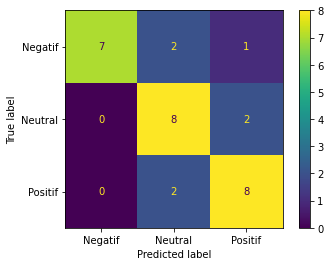

In [42]:
cm = confusion_matrix(testY, svc_pred_pso)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Negatif", "Neutral", "Positif"])

cm_display.plot()
plt.show()

Iteration: 1
Best (PSO): 0.3111111111111112
Iteration: 2
Best (PSO): 0.30000000000000016
Iteration: 3
Best (PSO): 0.30000000000000016
Iteration: 4
Best (PSO): 0.30000000000000016
Iteration: 5
Best (PSO): 0.30000000000000016
Iteration: 6
Best (PSO): 0.29999999999999993
Iteration: 7
Best (PSO): 0.29999999999999993
Iteration: 8
Best (PSO): 0.29999999999999993
Iteration: 9
Best (PSO): 0.2777777777777778
Iteration: 10
Best (PSO): 0.2777777777777778
Iteration: 11
Best (PSO): 0.2777777777777778
Iteration: 12
Best (PSO): 0.2777777777777778
Iteration: 13
Best (PSO): 0.2777777777777778
Iteration: 14
Best (PSO): 0.2777777777777778
Iteration: 15
Best (PSO): 0.2777777777777778
Iteration: 16
Best (PSO): 0.2777777777777778
Iteration: 17
Best (PSO): 0.2777777777777778
Iteration: 18
Best (PSO): 0.2777777777777778
Iteration: 19
Best (PSO): 0.2777777777777778
Iteration: 20
Best (PSO): 0.2777777777777778


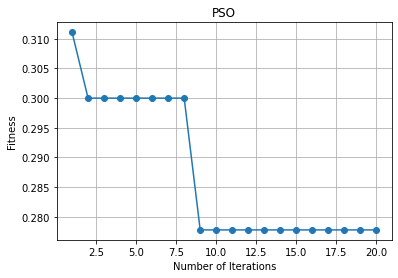

CPU times: user 48.8 s, sys: 27.2 s, total: 1min 16s
Wall time: 1min 16s


In [68]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 20  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [69]:
fmdl

{'param': array([[19.13631825,  0.59590477]]),
 'c': array([[0.31111111, 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778]])}

In [70]:
parameter = fmdl ['param'][0]

In [103]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C =  19.13631825,  gamma = 0.59590477))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.6777777777777777
Mean F1 Measure :  0.6781623828444845
Mean Precision  :  0.7043891293891295
Mean Recall     :  0.6759820426487093
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.7222222222222222
Mean F1 Measure :  0.7146773820978515
Mean Precision  :  0.7264158680825347
Mean Recall     :  0.720875420875421


Iteration: 1
Best (PSO): 0.30000000000000016
Iteration: 2
Best (PSO): 0.29999999999999993
Iteration: 3
Best (PSO): 0.29999999999999993
Iteration: 4
Best (PSO): 0.29999999999999993
Iteration: 5
Best (PSO): 0.29999999999999993
Iteration: 6
Best (PSO): 0.29999999999999993
Iteration: 7
Best (PSO): 0.28888888888888886
Iteration: 8
Best (PSO): 0.28888888888888886
Iteration: 9
Best (PSO): 0.28888888888888886
Iteration: 10
Best (PSO): 0.28888888888888886
Iteration: 11
Best (PSO): 0.28888888888888886
Iteration: 12
Best (PSO): 0.28888888888888886
Iteration: 13
Best (PSO): 0.28888888888888886
Iteration: 14
Best (PSO): 0.28888888888888886
Iteration: 15
Best (PSO): 0.28888888888888886
Iteration: 16
Best (PSO): 0.28888888888888886
Iteration: 17
Best (PSO): 0.2666666666666666
Iteration: 18
Best (PSO): 0.2666666666666666
Iteration: 19
Best (PSO): 0.2666666666666666
Iteration: 20
Best (PSO): 0.2666666666666666


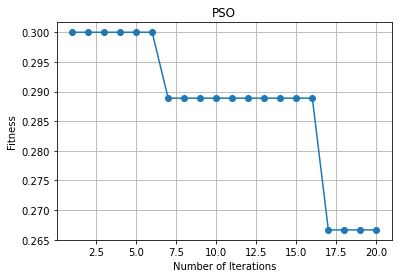

CPU times: user 1min 13s, sys: 41.2 s, total: 1min 54s
Wall time: 1min 55s


In [104]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 15    # number of particles
T    = 20  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [105]:
fmdl

{'param': array([[0.80278343, 0.53260158]]),
 'c': array([[0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.28888889, 0.28888889, 0.28888889, 0.28888889,
         0.28888889, 0.28888889, 0.28888889, 0.28888889, 0.28888889,
         0.28888889, 0.26666667, 0.26666667, 0.26666667, 0.26666667]])}

In [106]:
parameter = fmdl ['param'][0]

In [107]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.6777777777777777
Mean F1 Measure :  0.6781623828444845
Mean Precision  :  0.7043891293891295
Mean Recall     :  0.6759820426487093
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.7333333333333334
Mean F1 Measure :  0.7393906999192592
Mean Precision  :  0.769953194953195
Mean Recall     :  0.7325476992143658


In [22]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C =0.80278343, gamma = 0.53260158))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.6999999999999998
Mean F1 Measure :  0.701546349670929
Mean Precision  :  0.7227886002886003
Mean Recall     :  0.7023848373848374
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.6966666666666665
Mean F1 Measure :  0.7023923440867176
Mean Precision  :  0.7326025826025826
Mean Recall     :  0.7058909608909608


In [112]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.69      0.90      0.78        10
           2       0.80      0.80      0.80        10

    accuracy                           0.80        30
   macro avg       0.83      0.80      0.80        30
weighted avg       0.83      0.80      0.80        30



Iteration: 1
Best (PSO): 0.3111111111111112
Iteration: 2
Best (PSO): 0.29999999999999993
Iteration: 3
Best (PSO): 0.29999999999999993
Iteration: 4
Best (PSO): 0.29999999999999993
Iteration: 5
Best (PSO): 0.29999999999999993
Iteration: 6
Best (PSO): 0.29999999999999993
Iteration: 7
Best (PSO): 0.2777777777777778
Iteration: 8
Best (PSO): 0.2777777777777778
Iteration: 9
Best (PSO): 0.2777777777777778
Iteration: 10
Best (PSO): 0.2777777777777778
Iteration: 11
Best (PSO): 0.2777777777777778
Iteration: 12
Best (PSO): 0.2777777777777778
Iteration: 13
Best (PSO): 0.2777777777777778
Iteration: 14
Best (PSO): 0.2777777777777778
Iteration: 15
Best (PSO): 0.2777777777777778
Iteration: 16
Best (PSO): 0.2777777777777778
Iteration: 17
Best (PSO): 0.2777777777777778
Iteration: 18
Best (PSO): 0.2777777777777778
Iteration: 19
Best (PSO): 0.2777777777777778
Iteration: 20
Best (PSO): 0.2777777777777778


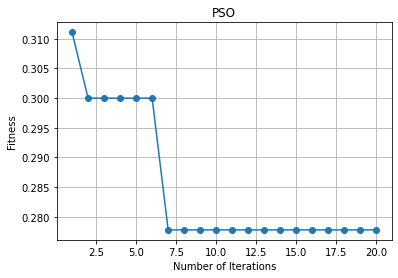

CPU times: user 1min 36s, sys: 54.3 s, total: 2min 31s
Wall time: 2min 31s


In [113]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 20    # number of particles
T    = 20  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [114]:
fmdl

{'param': array([[20.        ,  0.60977713]]),
 'c': array([[0.31111111, 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778]])}

In [115]:
parameter = fmdl['param'][0]

In [121]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.6777777777777777
Mean F1 Measure :  0.6781623828444845
Mean Precision  :  0.7043891293891295
Mean Recall     :  0.6759820426487093
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.7222222222222222
Mean F1 Measure :  0.7146773820978515
Mean Precision  :  0.7264158680825347
Mean Recall     :  0.720875420875421


In [122]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.58      0.70      0.64        10
           2       0.67      0.80      0.73        10

    accuracy                           0.70        30
   macro avg       0.75      0.70      0.70        30
weighted avg       0.75      0.70      0.70        30



# ITERASI 40

Iteration: 1
Best (PSO): 0.3111111111111112
Iteration: 2
Best (PSO): 0.3111111111111112
Iteration: 3
Best (PSO): 0.3111111111111112
Iteration: 4
Best (PSO): 0.30000000000000016
Iteration: 5
Best (PSO): 0.30000000000000016
Iteration: 6
Best (PSO): 0.30000000000000016
Iteration: 7
Best (PSO): 0.29999999999999993
Iteration: 8
Best (PSO): 0.29999999999999993
Iteration: 9
Best (PSO): 0.29999999999999993
Iteration: 10
Best (PSO): 0.29999999999999993
Iteration: 11
Best (PSO): 0.29999999999999993
Iteration: 12
Best (PSO): 0.29999999999999993
Iteration: 13
Best (PSO): 0.29999999999999993
Iteration: 14
Best (PSO): 0.29999999999999993
Iteration: 15
Best (PSO): 0.29999999999999993
Iteration: 16
Best (PSO): 0.29999999999999993
Iteration: 17
Best (PSO): 0.2777777777777778
Iteration: 18
Best (PSO): 0.2777777777777778
Iteration: 19
Best (PSO): 0.2777777777777778
Iteration: 20
Best (PSO): 0.2777777777777778
Iteration: 21
Best (PSO): 0.2777777777777778
Iteration: 22
Best (PSO): 0.2777777777777778
Iterat

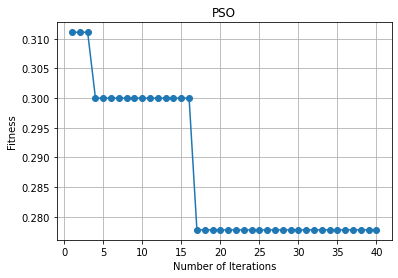

CPU times: user 1min 38s, sys: 54 s, total: 2min 32s
Wall time: 2min 33s


In [123]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 40  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [124]:
fmdl

{'param': array([[20.        ,  0.58556745]]),
 'c': array([[0.31111111, 0.31111111, 0.31111111, 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
         0.3       , 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778]])}

In [125]:
parameter = fmdl['param'][0]

In [126]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.6777777777777777
Mean F1 Measure :  0.6781623828444845
Mean Precision  :  0.7043891293891295
Mean Recall     :  0.6759820426487093
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.7222222222222222
Mean F1 Measure :  0.7146773820978515
Mean Precision  :  0.7264158680825347
Mean Recall     :  0.720875420875421


In [127]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.58      0.70      0.64        10
           2       0.67      0.80      0.73        10

    accuracy                           0.70        30
   macro avg       0.75      0.70      0.70        30
weighted avg       0.75      0.70      0.70        30



Iteration: 1
Best (PSO): 0.2777777777777778
Iteration: 2
Best (PSO): 0.2777777777777778
Iteration: 3
Best (PSO): 0.2777777777777778
Iteration: 4
Best (PSO): 0.2777777777777778
Iteration: 5
Best (PSO): 0.2777777777777778
Iteration: 6
Best (PSO): 0.2777777777777778
Iteration: 7
Best (PSO): 0.2777777777777778
Iteration: 8
Best (PSO): 0.2777777777777778
Iteration: 9
Best (PSO): 0.2777777777777778
Iteration: 10
Best (PSO): 0.2777777777777778
Iteration: 11
Best (PSO): 0.2777777777777778
Iteration: 12
Best (PSO): 0.2777777777777778
Iteration: 13
Best (PSO): 0.2777777777777778
Iteration: 14
Best (PSO): 0.2777777777777778
Iteration: 15
Best (PSO): 0.2777777777777778
Iteration: 16
Best (PSO): 0.2777777777777778
Iteration: 17
Best (PSO): 0.2777777777777778
Iteration: 18
Best (PSO): 0.2777777777777778
Iteration: 19
Best (PSO): 0.2777777777777778
Iteration: 20
Best (PSO): 0.2777777777777778
Iteration: 21
Best (PSO): 0.2777777777777777
Iteration: 22
Best (PSO): 0.2777777777777777
Iteration: 23
Best 

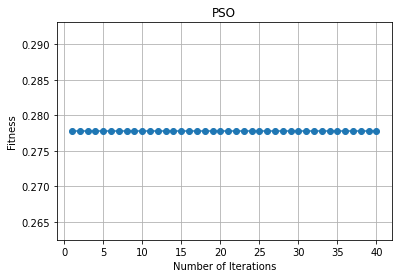

CPU times: user 2min 28s, sys: 1min 21s, total: 3min 49s
Wall time: 3min 50s


In [128]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 15    # number of particles
T    = 40  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [129]:
fmdl

{'param': array([[0.75532215, 0.75004519]]),
 'c': array([[0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778]])}

In [130]:
parameter = fmdl ['param'][0]

In [131]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.6777777777777777
Mean F1 Measure :  0.6781623828444845
Mean Precision  :  0.7043891293891295
Mean Recall     :  0.6759820426487093
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.7222222222222223
Mean F1 Measure :  0.7284803542263049
Mean Precision  :  0.7559930809930809
Mean Recall     :  0.7214365881032547


In [132]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.69      0.90      0.78        10
           2       0.80      0.80      0.80        10

    accuracy                           0.80        30
   macro avg       0.83      0.80      0.80        30
weighted avg       0.83      0.80      0.80        30



Iteration: 1
Best (PSO): 0.29999999999999993
Iteration: 2
Best (PSO): 0.2777777777777778
Iteration: 3
Best (PSO): 0.2777777777777778
Iteration: 4
Best (PSO): 0.2777777777777778
Iteration: 5
Best (PSO): 0.2777777777777778
Iteration: 6
Best (PSO): 0.2777777777777778
Iteration: 7
Best (PSO): 0.2777777777777778
Iteration: 8
Best (PSO): 0.2777777777777778
Iteration: 9
Best (PSO): 0.2777777777777778
Iteration: 10
Best (PSO): 0.2777777777777778
Iteration: 11
Best (PSO): 0.2777777777777778
Iteration: 12
Best (PSO): 0.2777777777777778
Iteration: 13
Best (PSO): 0.2777777777777778
Iteration: 14
Best (PSO): 0.2777777777777778
Iteration: 15
Best (PSO): 0.2777777777777778
Iteration: 16
Best (PSO): 0.2777777777777778
Iteration: 17
Best (PSO): 0.2777777777777778
Iteration: 18
Best (PSO): 0.2777777777777778
Iteration: 19
Best (PSO): 0.2777777777777778
Iteration: 20
Best (PSO): 0.2777777777777778
Iteration: 21
Best (PSO): 0.2777777777777778
Iteration: 22
Best (PSO): 0.2777777777777778
Iteration: 23
Best

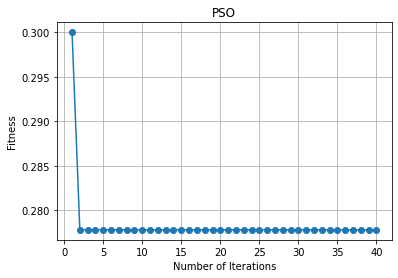

CPU times: user 3min 16s, sys: 1min 48s, total: 5min 5s
Wall time: 5min 6s


In [133]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 20    # number of particles
T    = 40  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [134]:
fmdl

{'param': array([[18.02075466,  0.60606198]]),
 'c': array([[0.3       , 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778]])}

In [135]:
parameter = fmdl ['param'][0]

In [136]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.6777777777777777
Mean F1 Measure :  0.6781623828444845
Mean Precision  :  0.7043891293891295
Mean Recall     :  0.6759820426487093
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.7222222222222222
Mean F1 Measure :  0.7146773820978515
Mean Precision  :  0.7264158680825347
Mean Recall     :  0.720875420875421


In [137]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.58      0.70      0.64        10
           2       0.67      0.80      0.73        10

    accuracy                           0.70        30
   macro avg       0.75      0.70      0.70        30
weighted avg       0.75      0.70      0.70        30



# ITERASI 80

Iteration: 1
Best (PSO): 0.30000000000000016
Iteration: 2
Best (PSO): 0.29999999999999993
Iteration: 3
Best (PSO): 0.29999999999999993
Iteration: 4
Best (PSO): 0.2777777777777778
Iteration: 5
Best (PSO): 0.2777777777777778
Iteration: 6
Best (PSO): 0.2777777777777778
Iteration: 7
Best (PSO): 0.2777777777777778
Iteration: 8
Best (PSO): 0.2777777777777778
Iteration: 9
Best (PSO): 0.2777777777777778
Iteration: 10
Best (PSO): 0.2777777777777778
Iteration: 11
Best (PSO): 0.2777777777777778
Iteration: 12
Best (PSO): 0.2777777777777778
Iteration: 13
Best (PSO): 0.2777777777777778
Iteration: 14
Best (PSO): 0.2777777777777778
Iteration: 15
Best (PSO): 0.2777777777777778
Iteration: 16
Best (PSO): 0.2777777777777778
Iteration: 17
Best (PSO): 0.2777777777777778
Iteration: 18
Best (PSO): 0.2777777777777778
Iteration: 19
Best (PSO): 0.2777777777777778
Iteration: 20
Best (PSO): 0.2777777777777778
Iteration: 21
Best (PSO): 0.2777777777777778
Iteration: 22
Best (PSO): 0.2777777777777778
Iteration: 23
Be

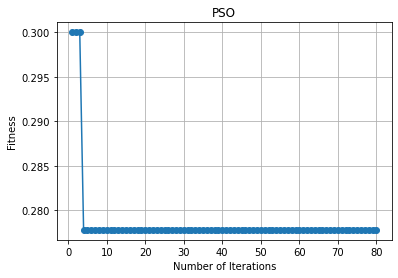

CPU times: user 3min 19s, sys: 1min 48s, total: 5min 7s
Wall time: 5min 8s


In [138]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 80  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [139]:
fmdl

{'param': array([[13.97457135,  0.57259874]]),
 'c': array([[0.3       , 0.3       , 0.3       , 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.2777

In [140]:
parameter = fmdl ['param'][0]

In [141]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.6777777777777777
Mean F1 Measure :  0.6781623828444845
Mean Precision  :  0.7043891293891295
Mean Recall     :  0.6759820426487093
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.7222222222222222
Mean F1 Measure :  0.7146773820978515
Mean Precision  :  0.7264158680825347
Mean Recall     :  0.720875420875421


In [143]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.58      0.70      0.64        10
           2       0.67      0.80      0.73        10

    accuracy                           0.70        30
   macro avg       0.75      0.70      0.70        30
weighted avg       0.75      0.70      0.70        30



Iteration: 1
Best (PSO): 0.30000000000000016
Iteration: 2
Best (PSO): 0.28888888888888886
Iteration: 3
Best (PSO): 0.28888888888888886
Iteration: 4
Best (PSO): 0.28888888888888886
Iteration: 5
Best (PSO): 0.28888888888888886
Iteration: 6
Best (PSO): 0.28888888888888886
Iteration: 7
Best (PSO): 0.28888888888888886
Iteration: 8
Best (PSO): 0.28888888888888886
Iteration: 9
Best (PSO): 0.28888888888888886
Iteration: 10
Best (PSO): 0.28888888888888886
Iteration: 11
Best (PSO): 0.28888888888888886
Iteration: 12
Best (PSO): 0.28888888888888886
Iteration: 13
Best (PSO): 0.28888888888888886
Iteration: 14
Best (PSO): 0.28888888888888886
Iteration: 15
Best (PSO): 0.28888888888888886
Iteration: 16
Best (PSO): 0.28888888888888886
Iteration: 17
Best (PSO): 0.28888888888888886
Iteration: 18
Best (PSO): 0.28888888888888886
Iteration: 19
Best (PSO): 0.28888888888888886
Iteration: 20
Best (PSO): 0.28888888888888886
Iteration: 21
Best (PSO): 0.28888888888888886
Iteration: 22
Best (PSO): 0.277777777777777

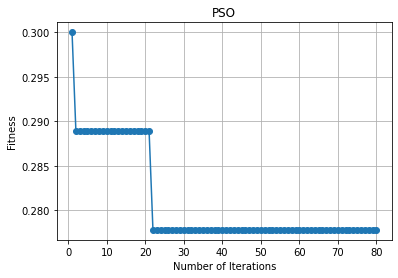

CPU times: user 4min 52s, sys: 2min 44s, total: 7min 37s
Wall time: 7min 38s


In [146]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 15    # number of particles
T    = 80  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [147]:
fmdl

{'param': array([[10.98679693,  0.62596968]]),
 'c': array([[0.3       , 0.28888889, 0.28888889, 0.28888889, 0.28888889,
         0.28888889, 0.28888889, 0.28888889, 0.28888889, 0.28888889,
         0.28888889, 0.28888889, 0.28888889, 0.28888889, 0.28888889,
         0.28888889, 0.28888889, 0.28888889, 0.28888889, 0.28888889,
         0.28888889, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.2777

In [148]:
parameter = fmdl ['param'][0]

In [149]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.6777777777777777
Mean F1 Measure :  0.6781623828444845
Mean Precision  :  0.7043891293891295
Mean Recall     :  0.6759820426487093
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.7222222222222222
Mean F1 Measure :  0.7146773820978515
Mean Precision  :  0.7264158680825347
Mean Recall     :  0.720875420875421


In [150]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.58      0.70      0.64        10
           2       0.67      0.80      0.73        10

    accuracy                           0.70        30
   macro avg       0.75      0.70      0.70        30
weighted avg       0.75      0.70      0.70        30



Iteration: 1
Best (PSO): 0.3111111111111112
Iteration: 2
Best (PSO): 0.29999999999999993
Iteration: 3
Best (PSO): 0.2888888888888891
Iteration: 4
Best (PSO): 0.2888888888888891
Iteration: 5
Best (PSO): 0.2888888888888891
Iteration: 6
Best (PSO): 0.2777777777777778
Iteration: 7
Best (PSO): 0.2777777777777778
Iteration: 8
Best (PSO): 0.2777777777777778
Iteration: 9
Best (PSO): 0.2777777777777778
Iteration: 10
Best (PSO): 0.2777777777777778
Iteration: 11
Best (PSO): 0.2777777777777778
Iteration: 12
Best (PSO): 0.2777777777777778
Iteration: 13
Best (PSO): 0.2777777777777778
Iteration: 14
Best (PSO): 0.2777777777777778
Iteration: 15
Best (PSO): 0.2777777777777778
Iteration: 16
Best (PSO): 0.2777777777777778
Iteration: 17
Best (PSO): 0.2777777777777778
Iteration: 18
Best (PSO): 0.2777777777777778
Iteration: 19
Best (PSO): 0.2777777777777778
Iteration: 20
Best (PSO): 0.2777777777777778
Iteration: 21
Best (PSO): 0.2777777777777778
Iteration: 22
Best (PSO): 0.2777777777777778
Iteration: 23
Best

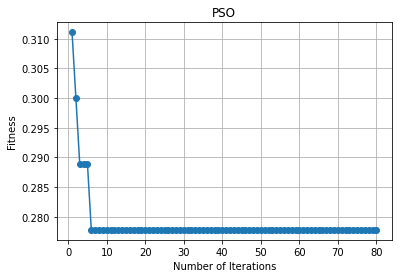

CPU times: user 6min 37s, sys: 3min 35s, total: 10min 13s
Wall time: 10min 16s


In [151]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 20    # number of particles
T    = 80  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [152]:
fmdl

{'param': array([[20.        ,  0.59853522]]),
 'c': array([[0.31111111, 0.3       , 0.28888889, 0.28888889, 0.28888889,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.2777

In [153]:
parameter = fmdl ['param'][0]

In [154]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.6777777777777777
Mean F1 Measure :  0.6781623828444845
Mean Precision  :  0.7043891293891295
Mean Recall     :  0.6759820426487093
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.7222222222222222
Mean F1 Measure :  0.7146773820978515
Mean Precision  :  0.7264158680825347
Mean Recall     :  0.720875420875421


In [155]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.58      0.70      0.64        10
           2       0.67      0.80      0.73        10

    accuracy                           0.70        30
   macro avg       0.75      0.70      0.70        30
weighted avg       0.75      0.70      0.70        30



# ITERASI 100

Iteration: 1
Best (PSO): 0.5777777777777777
Iteration: 2
Best (PSO): 0.44444444444444453
Iteration: 3
Best (PSO): 0.3111111111111112
Iteration: 4
Best (PSO): 0.30000000000000016
Iteration: 5
Best (PSO): 0.30000000000000016
Iteration: 6
Best (PSO): 0.30000000000000016
Iteration: 7
Best (PSO): 0.30000000000000016
Iteration: 8
Best (PSO): 0.2777777777777778
Iteration: 9
Best (PSO): 0.2777777777777778
Iteration: 10
Best (PSO): 0.2777777777777778
Iteration: 11
Best (PSO): 0.2777777777777778
Iteration: 12
Best (PSO): 0.2777777777777778
Iteration: 13
Best (PSO): 0.2777777777777778
Iteration: 14
Best (PSO): 0.2777777777777778
Iteration: 15
Best (PSO): 0.2777777777777778
Iteration: 16
Best (PSO): 0.2777777777777778
Iteration: 17
Best (PSO): 0.2777777777777778
Iteration: 18
Best (PSO): 0.2777777777777778
Iteration: 19
Best (PSO): 0.2777777777777778
Iteration: 20
Best (PSO): 0.2777777777777778
Iteration: 21
Best (PSO): 0.2777777777777778
Iteration: 22
Best (PSO): 0.2777777777777778
Iteration: 23


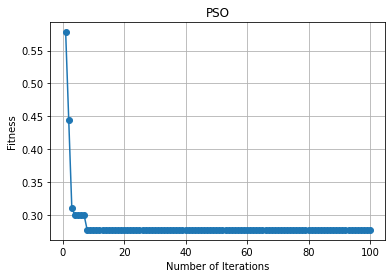

CPU times: user 4min 5s, sys: 2min 13s, total: 6min 19s
Wall time: 6min 20s


In [156]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 100  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [157]:
fmdl

{'param': array([[12.1429216 ,  0.57799873]]),
 'c': array([[0.57777778, 0.44444444, 0.31111111, 0.3       , 0.3       ,
         0.3       , 0.3       , 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.2777

In [158]:
parameter = fmdl ['param'][0]

In [159]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.6777777777777777
Mean F1 Measure :  0.6781623828444845
Mean Precision  :  0.7043891293891295
Mean Recall     :  0.6759820426487093
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.7222222222222222
Mean F1 Measure :  0.7146773820978515
Mean Precision  :  0.7264158680825347
Mean Recall     :  0.720875420875421


In [160]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.58      0.70      0.64        10
           2       0.67      0.80      0.73        10

    accuracy                           0.70        30
   macro avg       0.75      0.70      0.70        30
weighted avg       0.75      0.70      0.70        30



Iteration: 1
Best (PSO): 0.28666666666666674
Iteration: 2
Best (PSO): 0.28666666666666674
Iteration: 3
Best (PSO): 0.28
Iteration: 4
Best (PSO): 0.28
Iteration: 5
Best (PSO): 0.2733333333333333
Iteration: 6
Best (PSO): 0.2733333333333333
Iteration: 7
Best (PSO): 0.2733333333333333
Iteration: 8
Best (PSO): 0.2733333333333333
Iteration: 9
Best (PSO): 0.2733333333333333
Iteration: 10
Best (PSO): 0.2733333333333333
Iteration: 11
Best (PSO): 0.2733333333333333
Iteration: 12
Best (PSO): 0.2733333333333333
Iteration: 13
Best (PSO): 0.2733333333333333
Iteration: 14
Best (PSO): 0.2733333333333333
Iteration: 15
Best (PSO): 0.2733333333333333
Iteration: 16
Best (PSO): 0.2733333333333333
Iteration: 17
Best (PSO): 0.2733333333333333
Iteration: 18
Best (PSO): 0.2733333333333333
Iteration: 19
Best (PSO): 0.2733333333333333
Iteration: 20
Best (PSO): 0.2733333333333333
Iteration: 21
Best (PSO): 0.2733333333333333
Iteration: 22
Best (PSO): 0.2733333333333333
Iteration: 23
Best (PSO): 0.2733333333333333


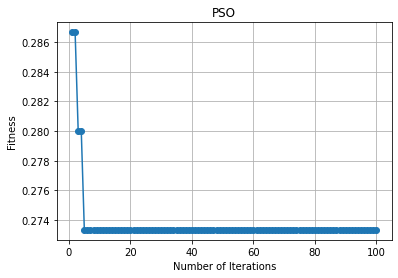

CPU times: user 10min 8s, sys: 5min 38s, total: 15min 47s
Wall time: 15min 51s


In [38]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 15    # number of particles
T    = 100  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [39]:
fmdl

{'param': array([[14.96272107,  2.5327439 ]]),
 'c': array([[0.28666667, 0.28666667, 0.28      , 0.28      , 0.27333333,
         0.27333333, 0.27333333, 0.27333333, 0.27333333, 0.27333333,
         0.27333333, 0.27333333, 0.27333333, 0.27333333, 0.27333333,
         0.27333333, 0.27333333, 0.27333333, 0.27333333, 0.27333333,
         0.27333333, 0.27333333, 0.27333333, 0.27333333, 0.27333333,
         0.27333333, 0.27333333, 0.27333333, 0.27333333, 0.27333333,
         0.27333333, 0.27333333, 0.27333333, 0.27333333, 0.27333333,
         0.27333333, 0.27333333, 0.27333333, 0.27333333, 0.27333333,
         0.27333333, 0.27333333, 0.27333333, 0.27333333, 0.27333333,
         0.27333333, 0.27333333, 0.27333333, 0.27333333, 0.27333333,
         0.27333333, 0.27333333, 0.27333333, 0.27333333, 0.27333333,
         0.27333333, 0.27333333, 0.27333333, 0.27333333, 0.27333333,
         0.27333333, 0.27333333, 0.27333333, 0.27333333, 0.27333333,
         0.27333333, 0.27333333, 0.27333333, 0.2733

In [40]:
parameter = fmdl ['param'][0]

In [41]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.6777777777777777
Mean F1 Measure :  0.6781623828444845
Mean Precision  :  0.7043891293891295
Mean Recall     :  0.6759820426487093
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.7111111111111111
Mean F1 Measure :  0.7088660936487022
Mean Precision  :  0.7254890171556839
Mean Recall     :  0.7105499438832772


Iteration: 1
Best (PSO): 0.30000000000000016
Iteration: 2
Best (PSO): 0.30000000000000016
Iteration: 3
Best (PSO): 0.2777777777777778
Iteration: 4
Best (PSO): 0.2777777777777778
Iteration: 5
Best (PSO): 0.2777777777777778
Iteration: 6
Best (PSO): 0.2777777777777778
Iteration: 7
Best (PSO): 0.2777777777777778
Iteration: 8
Best (PSO): 0.2777777777777778
Iteration: 9
Best (PSO): 0.2777777777777778
Iteration: 10
Best (PSO): 0.2777777777777778
Iteration: 11
Best (PSO): 0.2777777777777778
Iteration: 12
Best (PSO): 0.2777777777777778
Iteration: 13
Best (PSO): 0.2777777777777778
Iteration: 14
Best (PSO): 0.2777777777777778
Iteration: 15
Best (PSO): 0.2777777777777778
Iteration: 16
Best (PSO): 0.2777777777777778
Iteration: 17
Best (PSO): 0.2777777777777778
Iteration: 18
Best (PSO): 0.2777777777777778
Iteration: 19
Best (PSO): 0.2777777777777778
Iteration: 20
Best (PSO): 0.2777777777777778
Iteration: 21
Best (PSO): 0.2777777777777778
Iteration: 22
Best (PSO): 0.2777777777777778
Iteration: 23
Bes

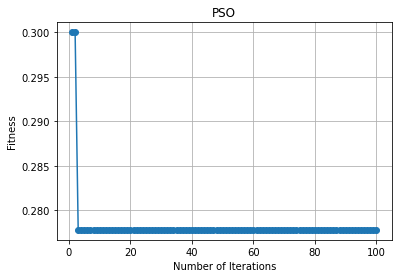

CPU times: user 8min 14s, sys: 4min 27s, total: 12min 41s
Wall time: 12min 45s


In [161]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 20    # number of particles
T    = 100  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [162]:
fmdl

{'param': array([[20.        ,  0.59458567]]),
 'c': array([[0.3       , 0.3       , 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.27777778, 0.27777778,
         0.27777778, 0.27777778, 0.27777778, 0.2777

In [45]:
parameter = fmdl['param'][0]

In [163]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.6777777777777777
Mean F1 Measure :  0.6781623828444845
Mean Precision  :  0.7043891293891295
Mean Recall     :  0.6759820426487093
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.7222222222222222
Mean F1 Measure :  0.7146773820978515
Mean Precision  :  0.7264158680825347
Mean Recall     :  0.720875420875421


In [164]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.58      0.70      0.64        10
           2       0.67      0.80      0.73        10

    accuracy                           0.70        30
   macro avg       0.75      0.70      0.70        30
weighted avg       0.75      0.70      0.70        30

